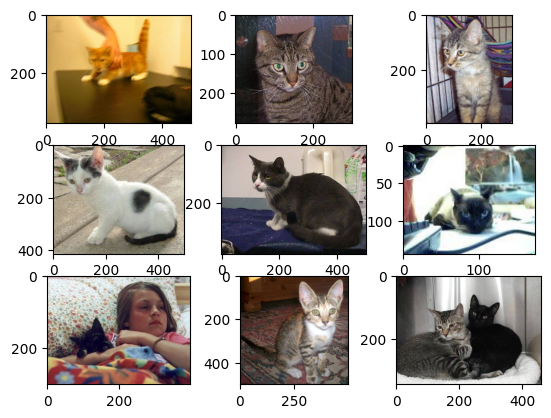

In [1]:
# plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

Selecione o tamanho da foto padronizada

In [2]:
# load dogs vs cats dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = 'train/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
	# determine class
	output = 0.0
	if file.startswith('dog'):
		output = 1.0
	# load image
	photo = load_img(folder + file, target_size=(200, 200))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
	labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

(101, 200, 200, 3) (101,)


Pré-processar fotos em diretórios padrão

In [3]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

Desenvolva um modelo CNN de linha de base

Found 117 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Epoch 1/20
2/2 [==============================] - 3s 2s/step - loss: 2.4294 - accuracy: 0.4872 - val_loss: 2.8559 - val_accuracy: 0.3788
Epoch 2/20
2/2 [==============================] - 2s 899ms/step - loss: 1.1164 - accuracy: 0.5897 - val_loss: 0.6848 - val_accuracy: 0.6212
Epoch 3/20
2/2 [==============================] - 2s 897ms/step - loss: 0.8107 - accuracy: 0.4615 - val_loss: 1.3019 - val_accuracy: 0.3788
Epoch 4/20
2/2 [==============================] - 2s 895ms/step - loss: 0.7506 - accuracy: 0.6496 - val_loss: 0.6644 - val_accuracy: 0.5909
Epoch 5/20
2/2 [==============================] - 2s 917ms/step - loss: 0.5944 - accuracy: 0.6667 - val_loss: 0.7546 - val_accuracy: 0.5455
Epoch 6/20
2/2 [==============================] - 2s 897ms/step - loss: 0.5718 - accuracy: 0.6838 - val_loss: 0.8335 - val_accuracy: 0.4545
Epoch 7/20
2/2 [==============================] - 2s 989ms/step - loss: 0.5245 - a

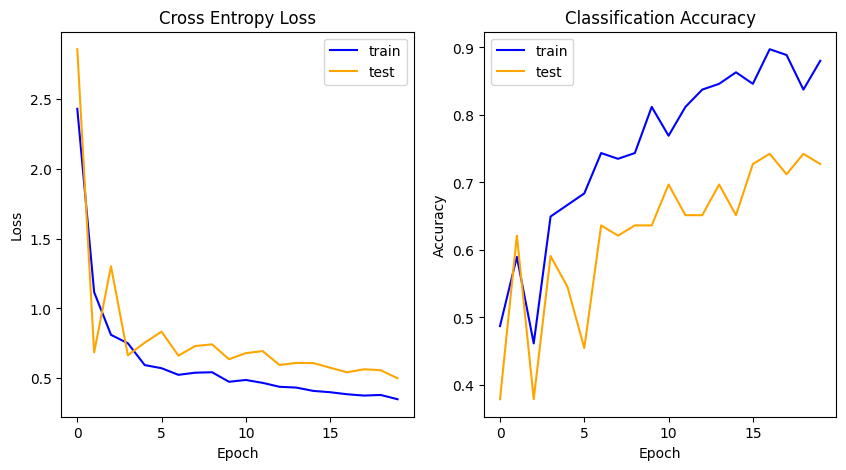

In [4]:
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Define a função para criar o modelo CNN
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # Compilar o modelo
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para plotar as curvas de perda e precisão
def plot_loss_accuracy(history):
    plt.figure(figsize=(10, 5))
    # Plotar a perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plotar a precisão
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Salvar o gráfico em um arquivo
    plt.savefig('learning_curves.png')
    plt.show()

# Função para treinar e avaliar o modelo
def run_test_harness():
    # Definir o modelo
    model = define_model()
    # Criar geradores de dados para treinamento e teste
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200))
    # Treinar o modelo
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
    # Avaliar o modelo
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('Test Accuracy: %.2f%%' % (acc * 100))
    # Plotar as curvas de perda e precisão
    plot_loss_accuracy(history)

# Ponto de entrada, executar o treinamento e avaliação do modelo
run_test_harness()


Modelo VGG de um bloco

Found 117 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Epoch 1/20
2/2 [==============================] - 2s 1s/step - loss: 30.3909 - accuracy: 0.4530 - val_loss: 15.6730 - val_accuracy: 0.3788
Epoch 2/20
2/2 [==============================] - 2s 965ms/step - loss: 4.3910 - accuracy: 0.5641 - val_loss: 0.8508 - val_accuracy: 0.3788
Epoch 3/20
2/2 [==============================] - 2s 875ms/step - loss: 0.6995 - accuracy: 0.6496 - val_loss: 0.7665 - val_accuracy: 0.3788
Epoch 4/20
2/2 [==============================] - 2s 958ms/step - loss: 0.6657 - accuracy: 0.6496 - val_loss: 0.7133 - val_accuracy: 0.4545
Epoch 5/20
2/2 [==============================] - 2s 944ms/step - loss: 0.6333 - accuracy: 0.7009 - val_loss: 0.7134 - val_accuracy: 0.5152
Epoch 6/20
2/2 [==============================] - 2s 871ms/step - loss: 0.5957 - accuracy: 0.7179 - val_loss: 0.7108 - val_accuracy: 0.5303
Epoch 7/20
2/2 [==============================] - 2s 880ms/step - loss: 0.5578 -

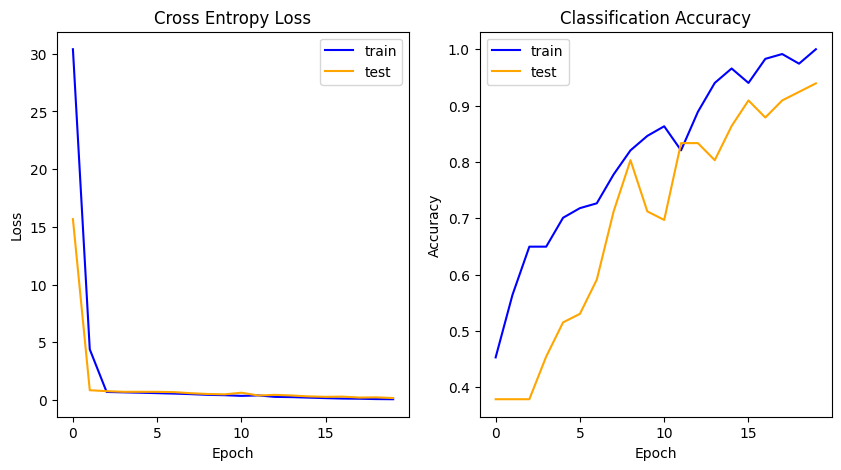

In [5]:
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Define a função para criar o modelo VGG de um bloco
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # Compilar o modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para plotar as curvas de perda e precisão
def plot_loss_accuracy(history):
    plt.figure(figsize=(10, 5))
    # Plotar a perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plotar a precisão
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Salvar o gráfico em um arquivo
    plt.savefig('learning_curves.png')
    plt.show()

# Função para treinar e avaliar o modelo
def run_test_harness():
    # Definir o modelo
    model = define_model()
    # Criar geradores de dados para treinamento e teste
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200))
    # Treinar o modelo
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
    # Avaliar o modelo
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('Test Accuracy: %.2f%%' % (acc * 100))
    # Plotar as curvas de perda e precisão
    plot_loss_accuracy(history)

# Ponto de entrada, executar o treinamento e avaliação do modelo
run_test_harness()


Modelo VGG de três blocos


Found 117 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Epoch 1/20
2/2 [==============================] - 4s 2s/step - loss: 1.9954 - accuracy: 0.6496 - val_loss: 5.3594 - val_accuracy: 0.6212
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 4.8029 - accuracy: 0.3504 - val_loss: 0.7033 - val_accuracy: 0.3788
Epoch 3/20
2/2 [==============================] - 3s 2s/step - loss: 0.6717 - accuracy: 0.6496 - val_loss: 0.7677 - val_accuracy: 0.3788
Epoch 4/20
2/2 [==============================] - 3s 2s/step - loss: 0.6524 - accuracy: 0.6496 - val_loss: 0.8588 - val_accuracy: 0.3788
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 0.6514 - accuracy: 0.6496 - val_loss: 0.7967 - val_accuracy: 0.3788
Epoch 6/20
2/2 [==============================] - 3s 2s/step - loss: 0.6253 - accuracy: 0.6496 - val_loss: 0.7243 - val_accuracy: 0.3788
Epoch 7/20
2/2 [==============================] - 3s 2s/step - loss: 0.6071 - accuracy: 0.7265 - 

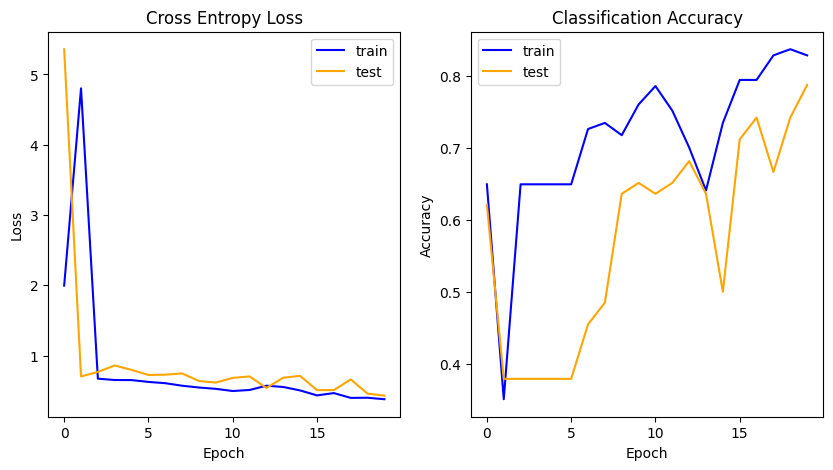

In [6]:
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Define a função para criar o modelo VGG de três blocos
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # Compilar o modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para treinar e avaliar o modelo VGG de três blocos
def run_test_harness():
    # Definir o modelo
    model = define_model()
    # Criar geradores de dados para treinamento e teste
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200))
    # Treinar o modelo
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
    # Avaliar o modelo
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('Test Accuracy: %.2f%%' % (acc * 100))
    # Plotar as curvas de perda e precisão
    plot_loss_accuracy(history)

# Ponto de entrada, executar o treinamento e avaliação do modelo VGG de três blocos
run_test_harness()


Modelo VGG de dois blocos

Found 117 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Epoch 1/20
2/2 [==============================] - 3s 2s/step - loss: 9.3901 - accuracy: 0.5897 - val_loss: 0.6467 - val_accuracy: 0.6212
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 0.7206 - accuracy: 0.3590 - val_loss: 0.7059 - val_accuracy: 0.3939
Epoch 3/20
2/2 [==============================] - 3s 1s/step - loss: 0.6685 - accuracy: 0.6581 - val_loss: 0.8271 - val_accuracy: 0.3788
Epoch 4/20
2/2 [==============================] - 3s 2s/step - loss: 0.6968 - accuracy: 0.6496 - val_loss: 0.8742 - val_accuracy: 0.3788
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 0.6646 - accuracy: 0.6752 - val_loss: 0.6933 - val_accuracy: 0.5455
Epoch 6/20
2/2 [==============================] - 3s 2s/step - loss: 0.6426 - accuracy: 0.6923 - val_loss: 0.8206 - val_accuracy: 0.3788
Epoch 7/20
2/2 [==============================] - 3s 1s/step - loss: 0.6218 - accuracy: 0.6496 - 

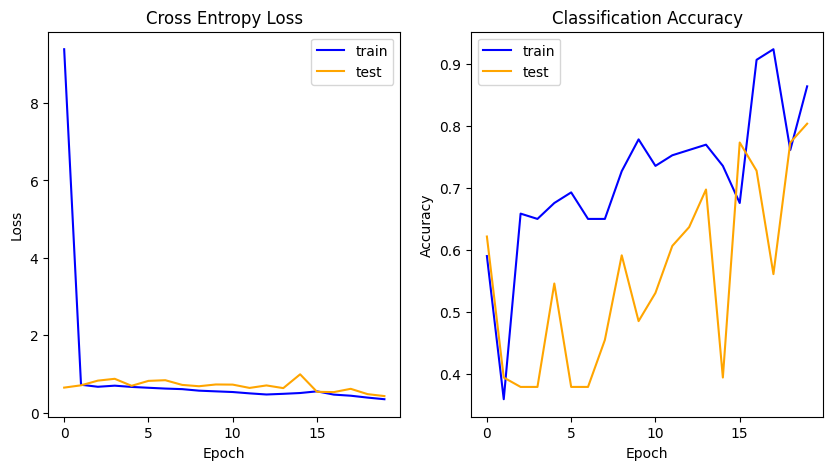

In [7]:
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Define a função para criar o modelo VGG de dois blocos
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # Compilar o modelo
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para treinar e avaliar o modelo VGG de dois blocos
def run_test_harness():
    # Definir o modelo
    model = define_model()
    # Criar geradores de dados para treinamento e teste
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200))
    # Treinar o modelo
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
    # Avaliar o modelo
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('Test Accuracy: %.2f%%' % (acc * 100))
    # Plotar as curvas de perda e precisão
    plot_loss_accuracy(history)

# Ponto de entrada, executar o treinamento e avaliação do modelo VGG de dois blocos
run_test_harness()


Regularização de Desistência

Found 117 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 1.2563 - accuracy: 0.5812 - val_loss: 0.6794 - val_accuracy: 0.6212
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 1.5340 - accuracy: 0.5299 - val_loss: 1.2848 - val_accuracy: 0.3788
Epoch 3/50
2/2 [==============================] - 3s 2s/step - loss: 1.0586 - accuracy: 0.5983 - val_loss: 0.6516 - val_accuracy: 0.6212
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 1.0130 - accuracy: 0.3590 - val_loss: 0.6933 - val_accuracy: 0.5152
Epoch 5/50
2/2 [==============================] - 4s 2s/step - loss: 0.6300 - accuracy: 0.6581 - val_loss: 0.7284 - val_accuracy: 0.3788
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 0.7019 - accuracy: 0.6325 - val_loss: 0.7458 - val_accuracy: 0.3788
Epoch 7/50
2/2 [==============================] - 3s 2s/step - loss: 0.6486 - accuracy: 0.6496 - 

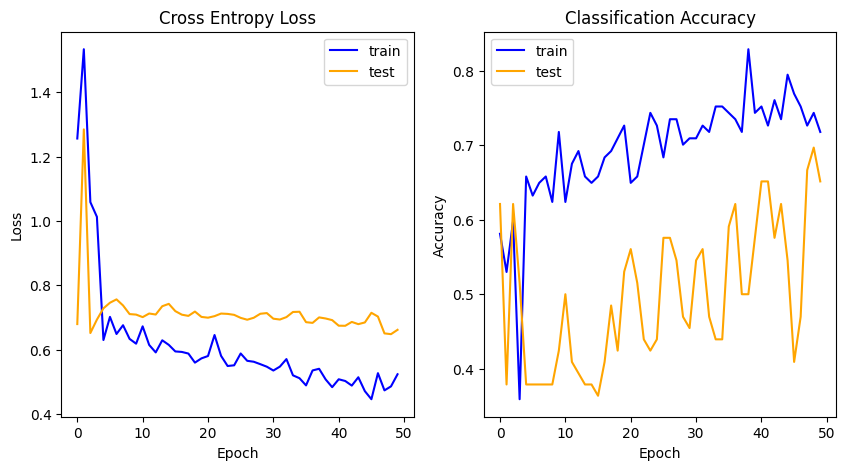

2/2 [==============================] - 0s 18ms/step - loss: 0.6616 - accuracy: 0.6515
Test Accuracy: 65.15%


In [8]:
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Define a função para criar o modelo com dropout
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compilar o modelo
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para plotar as curvas de perda e precisão
def plot_loss_accuracy(history):
    plt.figure(figsize=(10, 5))
    # Plotar a perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plotar a precisão
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Salvar o gráfico em um arquivo
    plt.savefig('learning_curves.png')
    plt.show()

# Função para treinar e avaliar o modelo com dropout
def run_test_harness():
    # Definir o modelo
    model = define_model()
    # Criar geradores de dados para treinamento e teste
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode='binary', batch_size=64, target_size=(200, 200))
    # Treinar o modelo
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
    # Plotar as curvas de perda e precisão
    plot_loss_accuracy(history)
    # Avaliar o modelo
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('Test Accuracy: %.2f%%' % (acc * 100))

# Ponto de entrada, executar o treinamento e avaliação do modelo com dropout
run_test_harness()


Aumento de dados de imagem

Found 117 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Epoch 1/50
2/2 [==============================] - 5s 2s/step - loss: 1.8066 - accuracy: 0.4701 - val_loss: 3.2807 - val_accuracy: 0.3788
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 3.0162 - accuracy: 0.6496 - val_loss: 0.7578 - val_accuracy: 0.3788
Epoch 3/50
2/2 [==============================] - 4s 2s/step - loss: 0.7792 - accuracy: 0.5470 - val_loss: 0.7202 - val_accuracy: 0.3788
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 0.7030 - accuracy: 0.5299 - val_loss: 0.7423 - val_accuracy: 0.3788
Epoch 5/50
2/2 [==============================] - 4s 2s/step - loss: 0.6771 - accuracy: 0.6154 - val_loss: 0.7300 - val_accuracy: 0.3788
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 0.6459 - accuracy: 0.6410 - val_loss: 0.7194 - val_accuracy: 0.3788
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 0.6322 - accuracy: 0.6410 - 

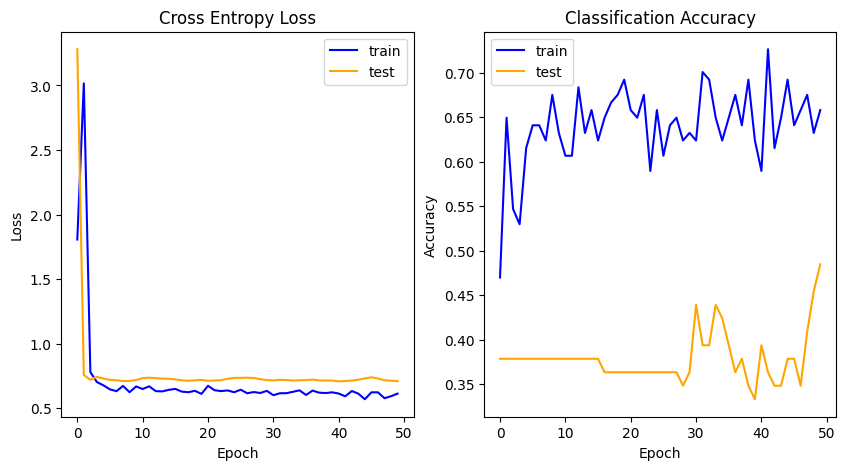

2/2 [==============================] - 0s 18ms/step - loss: 0.7098 - accuracy: 0.4848
Test Accuracy: 48.48%


In [9]:
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Define a função para criar o modelo com dropout
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compilar o modelo
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para plotar as curvas de perda e precisão
def plot_loss_accuracy(history):
    plt.figure(figsize=(10, 5))
    # Plotar a perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plotar a precisão
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Salvar o gráfico em um arquivo
    plt.savefig('learning_curves.png')
    plt.show()

# Função para treinar e avaliar o modelo com dropout
def run_test_harness():
    # Definir o modelo
    model = define_model()
    # Criar geradores de dados para treinamento e teste com aumento de dados
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                                 class_mode='binary',
                                                 batch_size=64,
                                                 target_size=(200, 200))
    test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                               class_mode='binary',
                                               batch_size=64,
                                               target_size=(200, 200))
    # Treinar o modelo
    history = model.fit(train_it, steps_per_epoch=len(train_it),
                        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
    # Plotar as curvas de perda e precisão
    plot_loss_accuracy(history)
    # Avaliar o modelo
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('Test Accuracy: %.2f%%' % (acc * 100))

# Ponto de entrada, executar o treinamento e avaliação do modelo
run_test_harness()


Explorar transferência de aprendizagem

Found 117 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Epoch 1/10


C:\Users\User\AppData\Local\Temp\ipykernel_17384\178028919.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),


2/2 [==============================] - 14s 9s/step - loss: 4.5418 - accuracy: 0.6838 - val_loss: 0.5883 - val_accuracy: 0.8939
Epoch 2/10
2/2 [==============================] - 14s 9s/step - loss: 0.8479 - accuracy: 0.9145 - val_loss: 0.9850 - val_accuracy: 0.9091
Epoch 3/10
2/2 [==============================] - 14s 9s/step - loss: 9.7260e-05 - accuracy: 1.0000 - val_loss: 0.2870 - val_accuracy: 0.9848
Epoch 4/10
2/2 [==============================] - 15s 10s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 0.9848
Epoch 5/10
2/2 [==============================] - 14s 10s/step - loss: 4.6386e-04 - accuracy: 1.0000 - val_loss: 0.1563 - val_accuracy: 0.9848
Epoch 6/10
2/2 [==============================] - 14s 9s/step - loss: 1.0078e-04 - accuracy: 1.0000 - val_loss: 0.1177 - val_accuracy: 0.9848
Epoch 7/10
2/2 [==============================] - 14s 10s/step - loss: 2.2198e-05 - accuracy: 1.0000 - val_loss: 0.0871 - val_accuracy: 0.9848
Epoch 8/10
2/2 [==========

C:\Users\User\AppData\Local\Temp\ipykernel_17384\178028919.py:64: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


Test Accuracy: 98.485%


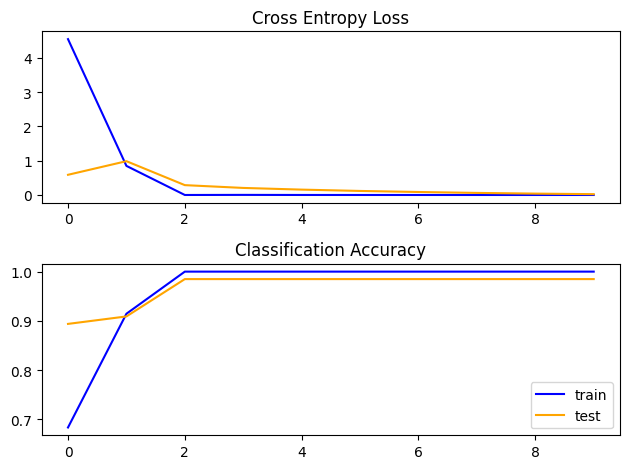

In [10]:
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    plt.tight_layout()
    # save plot to file
    plt.savefig('learning_curves.png')
    plt.show()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterator
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                           class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                          class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                                  validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('Test Accuracy: %.3f%%' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()


Salvar modelo final

In [21]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Define cnn model
def define_model():
    # Load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # Mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # Add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # Define new model
    model = Model(inputs=model.inputs, outputs=output)
    # Compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)  # Updated here
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Run the test harness for evaluating a model
def run_test_harness():
    # Define model
    model = define_model()
    # Create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # Specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    # Prepare iterator
    train_it = datagen.flow_from_directory('finalize_dogs_vs_cats/',
                                           class_mode='binary', batch_size=64, target_size=(224, 224))
    # Fit model
    model.fit(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=1)
    # Save model
    model.save('final_model.h5')

# Entry point, run the test harness
run_test_harness()


Found 66 images belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 6s 186ms/step - loss: 5.7541 - accuracy: 0.6212
Epoch 2/10
2/2 [==============================] - 5s 181ms/step - loss: 1.4115 - accuracy: 0.9091
Epoch 3/10
2/2 [==============================] - 5s 170ms/step - loss: 15.8747 - accuracy: 0.7727
Epoch 4/10
2/2 [==============================] - 5s 5s/step - loss: 9.2713 - accuracy: 0.8333
Epoch 5/10
2/2 [==============================] - 5s 5s/step - loss: 0.1246 - accuracy: 0.9848
Epoch 6/10
2/2 [==============================] - 5s 175ms/step - loss: 1.7461e-35 - accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 5s 5s/step - loss: 4.5444e-31 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 5s 5s/step - loss: 3.0860e-28 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 5s 5s/step - loss: 1.0253e-25 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 5s 5s/step - loss: 4.3332

1/1 [==============================] - 0s 192ms/step


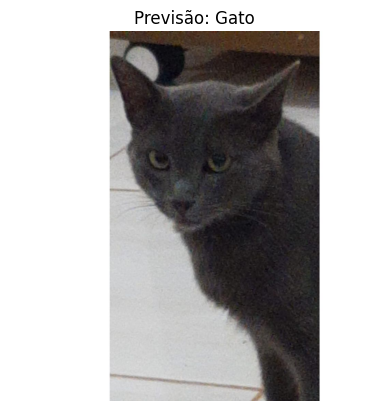

In [23]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image('sample_image.jpg')
    # load model
    model = load_model('final_model.h5')
    # predict the class
    result = model.predict(img)
    # convert the result to a human-readable label
    if result[0][0] > 0.5:
        prediction = 'Cachorro'
    else:
        prediction = 'Gato'
    
    # display the image with the prediction
    plt.imshow(load_img('sample_image.jpg'))
    plt.title('Previsão: {}'.format(prediction))
    plt.axis('off')
    plt.show()

# entry point, run the example
run_example()
